In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-26 00:31:35.117337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 00:31:35.117397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 00:31:35.118989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [9]:
# Prepare data
X = train.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y = pd.get_dummies(train['label']).values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test = test.drop(test.columns[0], axis=1).values.reshape(-1, 28, 28, 1) / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=8,
    zoom_range=[0.95, 1.05],
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)

# One-cycle learning rate scheduler
def one_cycle_lr(epoch, max_lr, total_epochs, start_lr=None, final_lr=None):
    if start_lr is None:
        start_lr = max_lr / 10
    if final_lr is None:
        final_lr = start_lr / 1000
    if epoch < total_epochs / 2:
        return (max_lr - start_lr) / (total_epochs / 2) * epoch + start_lr
    else:
        return -(max_lr - final_lr) / (total_epochs / 2) * (epoch - total_epochs / 2) + max_lr

total_epochs = 25
max_lr = 0.001

# Model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(265, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 265)            │       848,265 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 925,421 (3.53 MB)

 Trainable params: 925,421 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model checkpoint and learning rate scheduler
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
lr_scheduler = LearningRateScheduler(lambda epoch: one_cycle_lr(epoch, max_lr=max_lr, total_epochs=total_epochs))

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=total_epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, lr_scheduler]
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  16/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.1181 - loss: 2.2954

I0000 00:00:1714091756.948496    1159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714091756.965119    1159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 542/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5269 - loss: 1.4523

W0000 00:00:1714091767.303518    1159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7108 - loss: 0.8979

W0000 00:00:1714091781.763772    1160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.98167, saving model to best_model.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.7111 - loss: 0.8972 - val_accuracy: 0.9817 - val_loss: 0.0619 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1688 ━━━━━━━━━━━━━━━━━━━━ 2:46 98ms/step - accuracy: 0.9688 - loss: 0.1692

W0000 00:00:1714091782.440554    1162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9472 - loss: 0.1724
Epoch 2: val_accuracy improved from 0.98167 to 0.98850, saving model to best_model.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9472 - loss: 0.1723 - val_accuracy: 0.9885 - val_loss: 0.0385 - learning_rate: 1.7200e-04
Epoch 3/25
1681/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9628 - loss: 0.1208
Epoch 3: val_accuracy did not improve from 0.98850
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9628 - loss: 0.1208 - val_accuracy: 0.9885 - val_loss: 0.0438 - learning_rate: 2.4400e-04
Epoch 4/25
1679/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9721 - loss: 0.0903
Epoch 4: val_accuracy improved from 0.98850 to 0.99217, saving model to best_model.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9721 - loss: 0.0902 - val_accuracy: 0.9922 - val_loss: 0.0256 - learning_rate: 3.1600e-04
Epoch 5/25
1679/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0

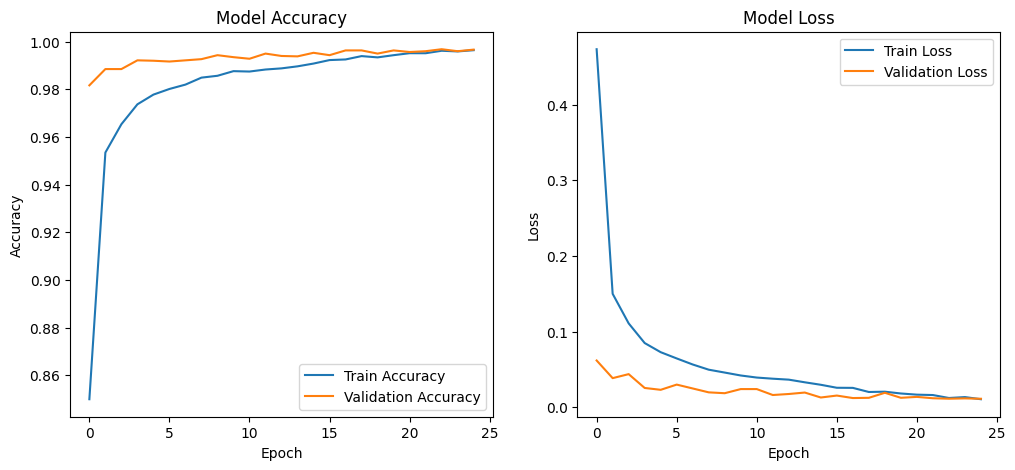

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [15]:
# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the best model on train set
loss, accuracy = best_model.evaluate(X_train, y_train)
print(f"Training Accuracy: {accuracy:.4f}")
print(f"Training Loss: {loss:.4f}")

# Evaluate the best model on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


  87/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 0.0015

W0000 00:00:1714092592.332017    1159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9985 - loss: 0.0048
Training Accuracy: 0.9985
Training Loss: 0.0047
 63/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0072   

W0000 00:00:1714092595.373985    1162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0097
Validation Accuracy: 0.9968
Validation Loss: 0.0114


115/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714092613.291822    1160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1714092613.759376    1159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


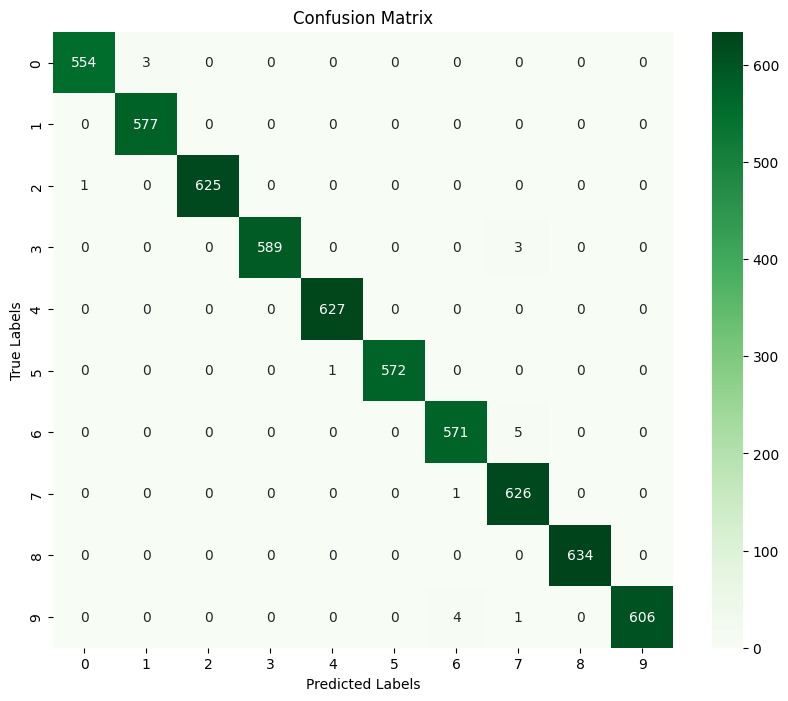

In [16]:
# Predict the validation set
val_predictions = best_model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val_classes, val_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [17]:
# Prepare submission file for the test predictions
test_predictions = best_model.predict(X_test)
test_predicted_classes = np.argmax(test_predictions, axis=1)
submission_df = pd.DataFrame({
    'id': test['id'],  # Ensure the 'id' column in test DataFrame is correct
    'label': test_predicted_classes
})
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print("Submission file created and saved as", submission_filename)
print(submission_df.head())


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Submission file created and saved as submission.csv
   id  label
0   0      3
1   1      0
2   2      2
3   3      6
4   4      7
